The purpose of this notebook is to manage the data necessary for MCU image classification. Because the classifier works with individual files, much of this notebook is dedicated to building a data pipeline, and populating the Train/Test folders appropriately.

In [1]:
import os
from distutils.dir_util import copy_tree
from shutil import copy, move, rmtree
import random
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
pip install pandas --user

     |████████████████████████████████| 10.0MB 1.8MB/s eta 0:00:01    |██████████████████████▉         | 7.2MB 2.1MB/s eta 0:00:02
     |████████████████████████████████| 512kB 1.3MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
working_directory = 'movie_frames'

In [3]:
%ls movie_frames/

american_bistro/  drillbit_taylor/  madea_funeral/      unearthed/
animals/          extremely_loud/   midnight_in_paris/  valentine/
ballon/           ford_v_ferrari/   mollys_game/        vault/
black_and_blue/   gemini/           monte_carlo/        warriors_way/
booksmart/        glory_road/       no_escape/          what_still_remains/
brooklyn/         hobbs_shaw/       parasite/           yesterday/
children_of_men/  hustle/           parts_you_lose/
downton_abbey/    john_wick_3/      plus_one/


In [4]:
#movie_directories = os.listdir(working_directory)

In [30]:
def get_frame_counts(working_directory):
    mcu_count = 0
    non_mcu_count = 0
    unlabeled_count = 0

    movie_directories = os.listdir(working_directory)
    
    for movie in movie_directories:
        movie_folder = os.path.join(working_directory, movie)
        mcu_folder = os.path.join(working_directory, movie, 'mcu')
        non_mcu_folder = os.path.join(working_directory, movie, 'non_mcu')

        unlabeled_count += len(os.listdir(movie_folder)) - 2
        mcu_count += len(os.listdir(mcu_folder))
        non_mcu_count += len(os.listdir(non_mcu_folder))
        
    print('There are', mcu_count, 'MCU frames')
    print('There are', non_mcu_count, 'non-MCU frames')
    print('There are', unlabeled_count, 'unlabeled frames')

    return mcu_count, non_mcu_count, unlabeled_count

In [31]:
mcu_count, non_mcu_count, unlabeled_count = get_frame_counts(working_directory)

There are 2394 MCU frames
There are 6870 non-MCU frames
There are 15484 unlabeled frames


In [6]:
def display_movie_labels(working_directory):
    mcu_frames_univ = []
    non_frames_univ = []
    movies = []
    
    # iterate through each film and designate the directory, then count number of frames in each category
    for movie in movie_directories:
        movie_folder = os.path.join(working_directory, movie)
        mcu_folder = os.path.join(movie_folder, 'mcu')
        non_mcu_folder = os.path.join(movie_folder, 'non_mcu')
        
        # create lists for use in pandas dataframe
        mcu_frames_univ.append(len(os.listdir(mcu_folder)))
        non_frames_univ.append(len(os.listdir(non_mcu_folder)))
        movies.append(movie)
        
        # count type of frame for print
        mcu_frames = len(os.listdir(mcu_folder))
        non_mcu_frames = len(os.listdir(non_mcu_folder))
        unlabeled_frames = len(os.listdir(movie_folder)) - 2

        # calculate percentages
        labeled_percentage = '{0:.2f}%'.format((mcu_frames + non_mcu_frames) / ((mcu_frames + non_mcu_frames + unlabeled_frames)) * 100)
        try:
            mcu_percentage = '{0:.2f}%'.format(mcu_frames / (mcu_frames + non_mcu_frames) * 100)
            non_mcu_percentage = '{0:.2f}%'.format(non_mcu_frames / (mcu_frames + non_mcu_frames) * 100)
        except ZeroDivisionError:
            mcu_percentage = '0.00%'
            non_mcu_percentage = '0.00%'
        
        # informational text
        print(movie + ', frames labeled:', labeled_percentage)
        print('\tMCU frames:\t\t', mcu_frames, '\t', mcu_percentage)
        print('\tNon-MCU frames:\t\t', non_mcu_frames, '\t', non_mcu_percentage)
        print('\tUnlabeled frames:\t', unlabeled_frames)
    
    return movies, mcu_frames_univ, non_frames_univ

In [7]:
movies, mcu_frames_univ, non_frames_univ = display_movie_labels(working_directory)

warriors_way, frames labeled: 33.47%
	MCU frames:		 79 	 31.23%
	Non-MCU frames:		 174 	 68.77%
	Unlabeled frames:	 503
hustle, frames labeled: 31.36%
	MCU frames:		 97 	 43.69%
	Non-MCU frames:		 125 	 56.31%
	Unlabeled frames:	 486
extremely_loud, frames labeled: 39.24%
	MCU frames:		 92 	 24.02%
	Non-MCU frames:		 291 	 75.98%
	Unlabeled frames:	 593
midnight_in_paris, frames labeled: 37.71%
	MCU frames:		 53 	 19.85%
	Non-MCU frames:		 214 	 80.15%
	Unlabeled frames:	 441
downton_abbey, frames labeled: 35.75%
	MCU frames:		 66 	 20.89%
	Non-MCU frames:		 250 	 79.11%
	Unlabeled frames:	 568
children_of_men, frames labeled: 100.00%
	MCU frames:		 49 	 7.06%
	Non-MCU frames:		 645 	 92.94%
	Unlabeled frames:	 0
john_wick_3, frames labeled: 31.68%
	MCU frames:		 56 	 17.95%
	Non-MCU frames:		 256 	 82.05%
	Unlabeled frames:	 673
what_still_remains, frames labeled: 28.74%
	MCU frames:		 57 	 28.79%
	Non-MCU frames:		 141 	 71.21%
	Unlabeled frames:	 491
gemini, frames labeled: 38.09%
	

In [8]:
arrays = [movies, mcu_frames_univ, non_frames_univ]
frames_df = pd.DataFrame(data = arrays).T
frames_df.columns = ['movie_title', 'mcu', 'non-mcu']

In [21]:
frames_df.head(2)

,movie_title,mcu,non-mcu
0,warriors_way,79,174
1,hustle,97,125


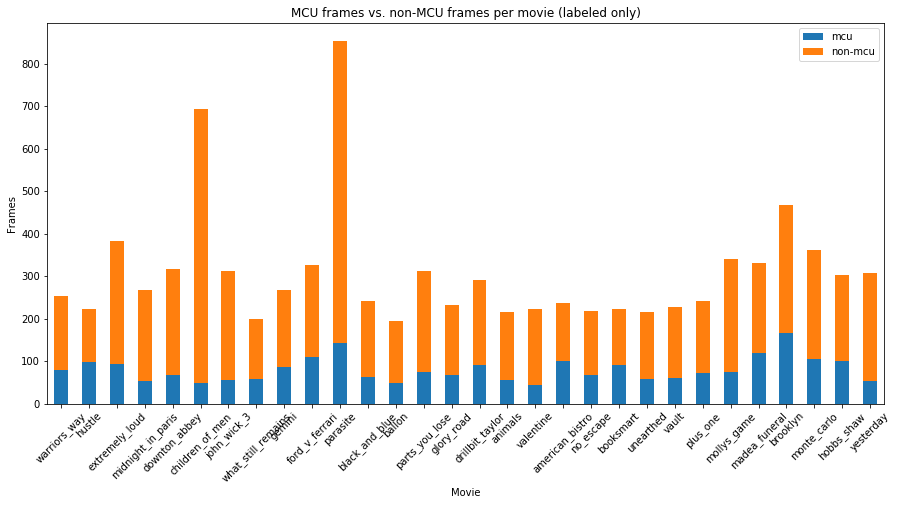

In [10]:
ax = frames_df.plot.bar(stacked=True, figsize=(15,7))
ax.set_title('MCU frames vs. non-MCU frames per movie (labeled only)')
ax.set_xlabel('Movie')
ax.set_xticklabels(frames_df.movie_title)
ax.set_ylabel('Frames')
plt.xticks(rotation=45)
plt.show()

In [11]:
frames_eda_df = frames_df.copy()
frames_eda_df['mcu_percentage'] = frames_eda_df['mcu'] / (frames_eda_df['mcu'] + frames_eda_df['non-mcu'])

In [19]:
frames_eda_df.head(2)

,movie_title,mcu,non-mcu,mcu_percentage
0,warriors_way,79,174,0.312253
1,hustle,97,125,0.436937


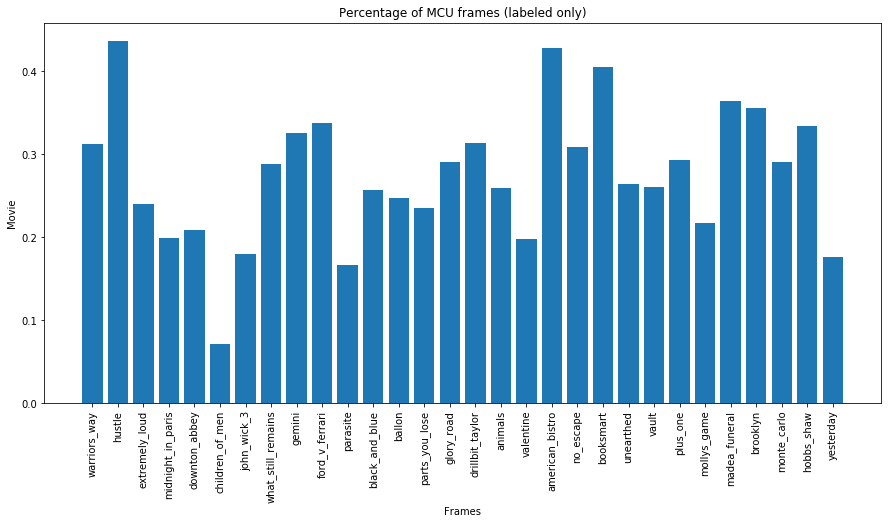

In [20]:
fig = plt.figure(figsize = (15,7))
ax = fig.gca()
ax.bar(frames_eda_df['movie_title'], frames_eda_df['mcu_percentage'])
ax.set_title('Percentage of MCU frames (labeled only)')
plt.xticks(rotation=90)
ax.set_xlabel('Frames')
ax.set_ylabel('Movie')
plt.show()

# Scenario 1: "Mixed Frames" Testing on frames from all movies

In [16]:
copy_directory = 'mixed_frames'

In [32]:
def populated_mixed_movies(working_directory, copy_directory, test_split, imbalance_removal):
    
    movie_directories = os.listdir(working_directory)
    
    # delete existing directories and files
    rmtree(os.path.join('mcu_data', copy_directory, 'train'))
    rmtree(os.path.join('mcu_data', copy_directory, 'test'))
    
    # create file structure
    os.mkdir(os.path.join('mcu_data', copy_directory, 'train'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'train/mcu'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'train/non_mcu'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'test'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'test/mcu'))
    os.mkdir(os.path.join('mcu_data', copy_directory, 'test/non_mcu'))
    
    # create variables for use within function 
    train_mcu_folder = os.path.join('mcu_data', copy_directory, 'train/mcu')
    train_non_folder = os.path.join('mcu_data', copy_directory, 'train/non_mcu')
    test_mcu_folder = os.path.join('mcu_data', copy_directory, 'test/mcu')
    test_non_folder = os.path.join('mcu_data', copy_directory, 'test/non_mcu')
    
    # move frames from each movie directory into Train's mcu and non_mcu folders
    for movie in movie_directories:
        movie_folder = os.path.join(working_directory, movie)
        mcu_folder = os.path.join(movie_folder, 'mcu')
        target_mcu_folder = os.path.join('mcu_data', copy_directory, 'train/mcu')  
        non_folder = os.path.join(movie_folder, 'non_mcu')
        target_non_folder = os.path.join('mcu_data', copy_directory, 'train/non_mcu')
        copy_tree(mcu_folder, target_mcu_folder)
        copy_tree(non_folder, target_non_folder)
    
    # take a random sample (test_split) of frames in Train and move to Test, for both mcu and non_mcu
    for frame in random.sample(os.listdir(train_mcu_folder), int(len(os.listdir(train_mcu_folder))* test_split)):
        move(os.path.join(train_mcu_folder, frame), test_mcu_folder)
    for frame in random.sample(os.listdir(train_non_folder), int(len(os.listdir(train_non_folder))* test_split)):
        move(os.path.join(train_non_folder, frame), test_non_folder)
    
    # remove certain percentage(imbalance_removal) of non-mcu frames from Train, because of class imbalance
    for frame in random.sample(os.listdir(train_non_folder), int(len(os.listdir(train_non_folder))* imbalance_removal)):
        os.remove(os.path.join(train_non_folder, frame))
    
    # informational text
    print('Moved', len(os.listdir(train_mcu_folder)), 'MCU images into Train')
    print('Moved', len(os.listdir(train_non_folder)), 'non-MCU images into Train')
    print('Moved', len(os.listdir(test_mcu_folder)), 'MCU images into Test')
    print('Moved', len(os.listdir(test_non_folder)), 'non-MCU images into Test')

In [33]:
populated_mixed_movies(working_directory, copy_directory, test_split=.2, imbalance_removal=.4)

Moved 1916 MCU images into Train
Moved 3298 non-MCU images into Train
Moved 478 MCU images into Test
Moved 1374 non-MCU images into Test


## Scenario 2: Keeping certain movies' frames out of Train, and exclusively Testing on these movies